In [1]:
%load_ext autoreload
%autoreload 2


from ATSDS import ATSDS
import matplotlib.pyplot as plt

import torch
from torchvision import transforms as transforms
## Standard libraries
import os
import json
import math
import random
import numpy as np 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
CUDA_LAUNCH_BLOCKING=1

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


transform_train = transforms.Compose(
    [transforms.Resize(256),
    transforms.RandomCrop(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

transform_test = transforms.Compose(
    [transforms.Resize(256),
    transforms.CenterCrop(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


def load_model(model,optimizer,scheduler,filepath):
    cpt = torch.load(filepath,map_location=torch.device('cpu'))
    model.load_state_dict(cpt['model'])
    optimizer.load_state_dict(cpt['optimizer'])
    scheduler.load_state_dict(cpt['scheduler'])
    return cpt['epoch'], cpt['trainstats']

def test_model(model, testloader,criterion,debug_prints=False):
    model.eval()
    num_classes = len(testloader.dataset.get_classes())
    correct = torch.zeros(num_classes, dtype=torch.int64, device=device)
    correct_top5 = torch.zeros(num_classes, dtype=torch.int64, device=device)
    total = torch.zeros(num_classes, dtype=torch.int64, device=device)
    softmaxes = torch.zeros(num_classes, dtype=torch.float, device=device)
    scores = torch.zeros(num_classes, dtype=torch.float, device=device)
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the GPU
            outputs = model(images)
            softmax =  F.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)  # Calculate the loss
            test_loss += loss.item()  # Accumulate the loss

            _, predicted = torch.max(outputs, 1)
            _, predicted_top5 = torch.topk(outputs, 5, 1)


            for i in range(len(predicted)):
                correct[labels[i]] += (predicted[i] == labels[i])
                correct_top5[labels[i]] += (labels[i] in predicted_top5[i])
                total[labels[i]] += 1
                softmaxes[labels[i]] += softmax[i][labels[i]]
                scores[labels[i]] += outputs[i][labels[i]]


    accuracy_per_class = (correct.float() / total.float())
    top5_accuracy_per_class = (correct_top5.float() / total.float())
    test_loss /= len(testloader)  # Calculate the average test loss

    if debug_prints:
        print(f'Test Total Accuracy: {accuracy_per_class.mean():.2%}')
        print(f'Test Total Top-5 Accuracy: {top5_accuracy_per_class.mean():.2%}')

        for i in range(num_classes):
            print(f'Class {i} Test Accuracy: {accuracy_per_class[i]:.2%}')
            print(f'Class {i} Test Top-5 Accuracy: {top5_accuracy_per_class[i]:.2%}')

    model.train()  # Set the model back to training mode

    return correct.cpu().numpy(), correct_top5.cpu().numpy(), total.cpu().numpy(), test_loss, softmaxes.cpu().numpy(),scores.cpu().numpy()

    
DATASET_PATH = "data/auswertung/"
MODEL_NAME = "convnext_tiny"
XAI_NAME = "gradcam"
ADV_PCT = "10"
dataset_type = "occlusion/10/"
dataset_split = "test"
ROOT_PATH = DATASET_PATH + MODEL_NAME + "/" + XAI_NAME + "/"

CHECKPOINT_PATH = "model/"
RANDOM_SEED = 1414

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Used for reproducability to fix randomness in some GPU calculations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [2]:
testset = ATSDS(root=ROOT_PATH, split=dataset_split, dataset_type=dataset_type, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = True, num_workers = 2)


data\auswertung\convnext_tiny\gradcam\occlusion\10\test


In [3]:
from model import get_model

model = get_model(model_name = MODEL_NAME, n_classes = testset.get_num_classes())
model = model.to(device)


C:\Users\Julia\anaconda3\envs\lib\site-packages\torchvision\ops\misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [4]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,200)


In [5]:
epoch,trainstats = load_model(model, optimizer, scheduler, CHECKPOINT_PATH + MODEL_NAME + "_1_1.tar")
train_loss = trainstats[0]
test_loss = trainstats[1]
train_stats= trainstats[2]

xai_methods = ["gradcam","ig_fixpoints","lime","prism","xrai"]

performance_xai_type = {}


In [47]:

for current_method in xai_methods:
    ROOT_PATH = DATASET_PATH + MODEL_NAME + "/" + current_method + "/"
    c_list = []
    c_5_list = []
    softmaxes_list = []
    scores_list = []
    losses = []
    
    for pct in range(0,101,10):
        dataset_type = "occlusion/" + str(pct) 
        testset = ATSDS(root=ROOT_PATH, split=dataset_split, dataset_type=dataset_type, transform=transform_test)
        testloader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = True, num_workers = 2)
        c,c_5,t,loss,softmaxes,scores = test_model(model,testloader,loss_criterion)
        c_list.append(c)
        c_5_list.append(c_5)
        softmaxes_list.append(softmaxes)
        scores_list.append(scores)
    performance_xai_type[current_method] = (c_list,c_5_list,softmaxes_list,scores_list,losses)
    
total = t


data\auswertung\convnext_tiny\gradcam\occlusion\0\test
data\auswertung\convnext_tiny\gradcam\occlusion\10\test
data\auswertung\convnext_tiny\gradcam\occlusion\20\test
data\auswertung\convnext_tiny\gradcam\occlusion\30\test
data\auswertung\convnext_tiny\gradcam\occlusion\40\test
data\auswertung\convnext_tiny\gradcam\occlusion\50\test
data\auswertung\convnext_tiny\gradcam\occlusion\60\test
data\auswertung\convnext_tiny\gradcam\occlusion\70\test
data\auswertung\convnext_tiny\gradcam\occlusion\80\test
data\auswertung\convnext_tiny\gradcam\occlusion\90\test
data\auswertung\convnext_tiny\gradcam\occlusion\100\test
data\auswertung\convnext_tiny\ig_fixpoints\occlusion\0\test
data\auswertung\convnext_tiny\ig_fixpoints\occlusion\10\test
data\auswertung\convnext_tiny\ig_fixpoints\occlusion\20\test
data\auswertung\convnext_tiny\ig_fixpoints\occlusion\30\test
data\auswertung\convnext_tiny\ig_fixpoints\occlusion\40\test
data\auswertung\convnext_tiny\ig_fixpoints\occlusion\50\test
data\auswertung\con

In [6]:
import pickle 

#with open(DATASET_PATH + MODEL_NAME + "occ_results.pkl", 'wb') as f:
#    pickle.dump(performance_xai_type, f)


In [7]:
with open(DATASET_PATH + MODEL_NAME + "occ_results.pkl", 'rb') as f:
    performance_xai_type = pickle.load(f)


In [8]:
accuracies = []
for current_method in xai_methods:
    correct,correct_5,softmax,score,loss = performance_xai_type[current_method]
    accuracy = np.mean((np.divide(correct,50)),axis=1)
    accuracies.append(accuracy)

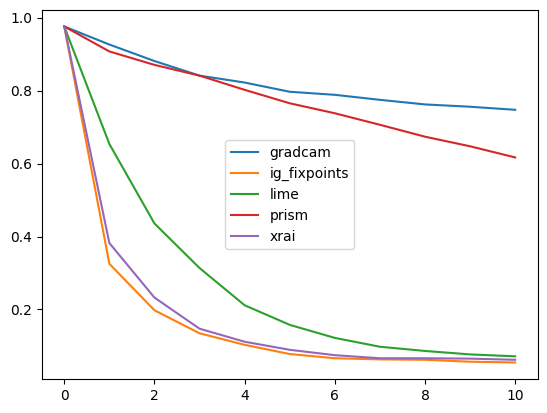

In [9]:
for i,entry in enumerate(accuracies):
    plt.plot(entry)
    plt.legend(xai_methods)

In [10]:
print(accuracies)

[array([0.97578947, 0.92631579, 0.88105263, 0.84105263, 0.82210526,
       0.79684211, 0.78842105, 0.77473684, 0.76210526, 0.75578947,
       0.74736842]), array([0.97578947, 0.32526316, 0.19789474, 0.13473684, 0.10315789,
       0.07789474, 0.06631579, 0.06315789, 0.06210526, 0.05684211,
       0.05473684]), array([0.97578947, 0.65368421, 0.43578947, 0.31368421, 0.21157895,
       0.15789474, 0.12210526, 0.09789474, 0.08631579, 0.07684211,
       0.07157895]), array([0.97578947, 0.90736842, 0.87052632, 0.84105263, 0.80210526,
       0.76526316, 0.73789474, 0.70631579, 0.67368421, 0.64736842,
       0.61684211]), array([0.97578947, 0.38210526, 0.23263158, 0.14736842, 0.11157895,
       0.08947368, 0.07473684, 0.06631579, 0.06631579, 0.06526316,
       0.06210526])]


In [11]:
print(xai_methods)

['gradcam', 'ig_fixpoints', 'lime', 'prism', 'xrai']


In [12]:
performance_xai_resnet = pickle.load(open(DATASET_PATH + "resnet50" + "occ_results.pkl", 'rb'))
performance_xai_convnext_tiny = pickle.load(open(DATASET_PATH + "convnext_tiny" + "occ_results.pkl", 'rb'))
performance_xai_simple_cnn = pickle.load(open(DATASET_PATH + "simple_cnn" + "occ_results.pkl", 'rb'))
performance_xai_vgg16 = pickle.load(open(DATASET_PATH + "vgg16" + "occ_results.pkl", 'rb'))
perf_tables = [performance_xai_simple_cnn,performance_xai_vgg16,performance_xai_resnet,performance_xai_convnext_tiny]
perf_tables_CNNs = ["Simple CNN", "VGG16", "ResNet50", "ConvNeXt-T"]

In [13]:
accuracies_all = []
for performance_xai_type in perf_tables:
    accuracies = []
    for current_method in xai_methods:
        print(current_method)
        correct,correct_5,softmax,score,loss = performance_xai_type[current_method]
        accuracy = np.mean((np.divide(correct,50)),axis=1)
        accuracies.append(accuracy)
    accuracies_all.append(accuracies)

gradcam
ig_fixpoints
lime
prism
xrai
gradcam
ig_fixpoints
lime
prism
xrai
gradcam
ig_fixpoints
lime
prism
xrai
gradcam
ig_fixpoints
lime
prism
xrai


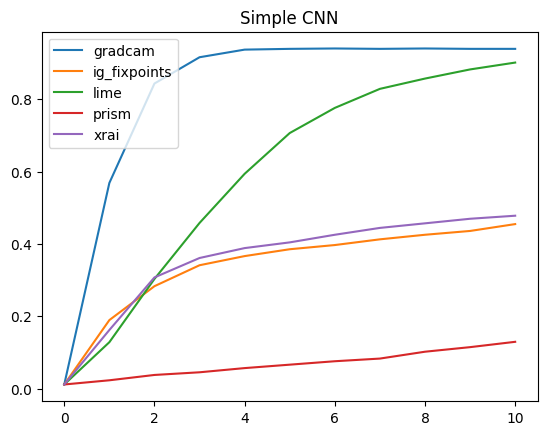

[array([0.98842105, 0.43157895, 0.15684211, 0.08421053, 0.06315789,
       0.06105263, 0.06      , 0.06105263, 0.06      , 0.06105263,
       0.06105263]), array([0.98842105, 0.81052632, 0.71684211, 0.65894737, 0.63368421,
       0.61473684, 0.60315789, 0.58736842, 0.57473684, 0.56421053,
       0.54526316]), array([0.98842105, 0.87157895, 0.69684211, 0.54210526, 0.40631579,
       0.29368421, 0.22421053, 0.17157895, 0.14315789, 0.11789474,
       0.09894737]), array([0.98842105, 0.97684211, 0.96210526, 0.95473684, 0.94315789,
       0.93368421, 0.92421053, 0.91684211, 0.89789474, 0.88526316,
       0.87052632]), array([0.98842105, 0.83789474, 0.69263158, 0.63894737, 0.61157895,
       0.59578947, 0.57473684, 0.55578947, 0.54315789, 0.53052632,
       0.52210526])]


In [14]:
for entry in accuracies_all[0]:
    plt.plot(1-entry)
plt.legend(xai_methods)
plt.title('Simple CNN')
plt.show()
print(accuracies_all[0])

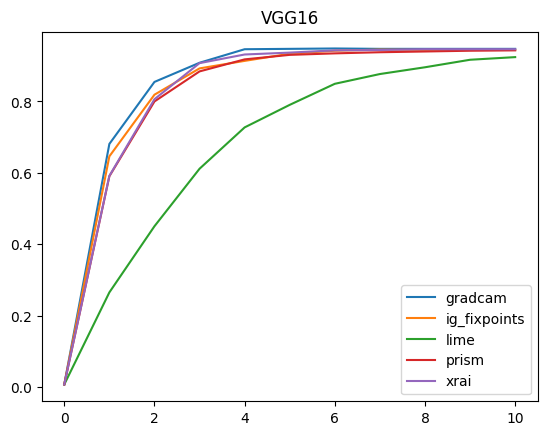

[array([0.99263158, 0.31894737, 0.14526316, 0.09157895, 0.05368421,
       0.05263158, 0.05157895, 0.05263158, 0.05263158, 0.05263158,
       0.05263158]), array([0.99263158, 0.35368421, 0.18105263, 0.10736842, 0.08631579,
       0.06631579, 0.05789474, 0.05473684, 0.05578947, 0.05578947,
       0.05578947]), array([0.99263158, 0.73473684, 0.54947368, 0.38842105, 0.27263158,
       0.20947368, 0.15052632, 0.12315789, 0.10421053, 0.08315789,
       0.07578947]), array([0.99263158, 0.40947368, 0.2       , 0.11578947, 0.08210526,
       0.06947368, 0.06526316, 0.06210526, 0.06      , 0.05789474,
       0.05684211]), array([0.99263158, 0.40842105, 0.19368421, 0.09263158, 0.06842105,
       0.06315789, 0.05684211, 0.05578947, 0.05368421, 0.05368421,
       0.05368421])]


In [15]:
for entry in accuracies_all[1]:
    plt.plot(1-entry)
plt.legend(xai_methods)
plt.title('VGG16')
plt.show()
print(accuracies_all[1])

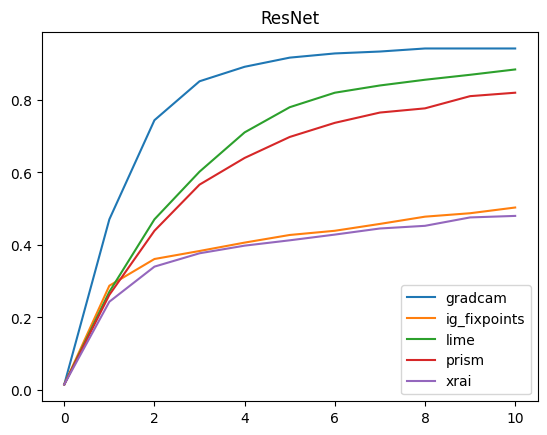

In [16]:
for entry in accuracies_all[2]:
    plt.plot(1-entry)
plt.legend(xai_methods)
plt.title('ResNet')
plt.show()

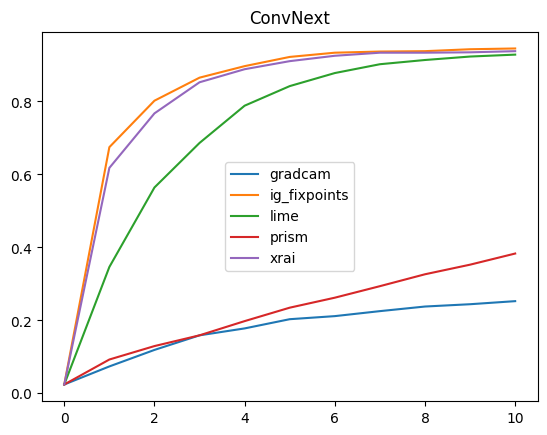

In [17]:
for entry in accuracies_all[3]:
    plt.plot(1-entry)
plt.legend(xai_methods)
plt.title('ConvNext')
plt.show()

In [18]:
print([x for x in accuracies_all[3]])

[array([0.97578947, 0.92631579, 0.88105263, 0.84105263, 0.82210526,
       0.79684211, 0.78842105, 0.77473684, 0.76210526, 0.75578947,
       0.74736842]), array([0.97578947, 0.32526316, 0.19789474, 0.13473684, 0.10315789,
       0.07789474, 0.06631579, 0.06315789, 0.06210526, 0.05684211,
       0.05473684]), array([0.97578947, 0.65368421, 0.43578947, 0.31368421, 0.21157895,
       0.15789474, 0.12210526, 0.09789474, 0.08631579, 0.07684211,
       0.07157895]), array([0.97578947, 0.90736842, 0.87052632, 0.84105263, 0.80210526,
       0.76526316, 0.73789474, 0.70631579, 0.67368421, 0.64736842,
       0.61684211]), array([0.97578947, 0.38210526, 0.23263158, 0.14736842, 0.11157895,
       0.08947368, 0.07473684, 0.06631579, 0.06631579, 0.06526316,
       0.06210526])]


In [23]:
fig, ax = plt.subplots(2,2,figsize=(10,10),sharey=True,dpi=800)
for i in range(4):
    for entry in accuracies_all[i]:
        ax[i%2][i//2].plot(1-entry)
        ax[i%2][i//2].set_title(perf_tables_CNNs[i])
        ax[i%2][i//2].set_xticks([x for x in range(11)],[str(x) + "%" for x in range(11)])
        ax[i%2][i//2].set_yticks([0,0.2,0.4,0.6,0.8,1.0],[str(x) + "%" for x in range(0,101,20)])
        ax[i%2][i//2]

ax[1][0].legend(xai_methods)

fig.text(0.5,0.0,"Occluded Percentage", ha = 'center')
fig.text(0.0,0.5,"Test-Accuracy", ha = 'center', rotation='vertical')
plt.tight_layout()
plt.show()